<a href="https://colab.research.google.com/github/jmquintana/data_science_sprint_2/blob/main/JoseQuintanaProyecto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sprint Proyect 2**

#### Ingeniería de Features, Modelos Avanzados e Interpretación de Modelos (4 sprints)
***

### **Story Points**
<img src='https://s3.amazonaws.com/platform-resources.acamica.com/slides/Im%C3%A1genes+en+Toolboxes/DS+(4+Sprints)/ds_sprintproject2_a_actuallizado.png' >

### **Transformación de Datos**
***

##### **Carga del dataset**

In [ ]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
# Le doy formato a los gráficos
sns.set_style("darkgrid")
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [ ]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Codigo para poder imprimir multiples outputs en una misma línea
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Monto mi Google Drive para cargar el DataSet
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargo el DataSet con Pandas como un DataFrame nombrado "df"
# Previamente debe descargarse del siguiente link: https://drive.google.com/uc?export=download&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS_Proyecto_01_Datos_Properati.csv")
# df = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

In [ ]:
print("Columnas:",df.shape[1])
print("Filas:",df.shape[0])

Columnas: 19
Filas: 146660


In [ ]:
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.6059,-58.3849,Argentina,Capital Federal,San Cristobal,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.6241,-58.4121,Argentina,Capital Federal,Boedo,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.5936,-58.4275,Argentina,Capital Federal,Palermo,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.5813,-58.4368,Argentina,Capital Federal,Palermo,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.9142,-57.9382,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [ ]:
# Elimino columnas que no necesitaré y renombro las columnas
df = df[['lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'property_type']]
df = df.rename({'l2':'zona', 'l3':'barrio', 'rooms':'ambientes', 'bedrooms':'dormitorios', 'bathrooms':'baños', 'surface_total':'sup_total', 'surface_covered':'sup_cubierta', 'price':'precio', 'property_type':'tipo'}, axis=1)
df.head()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
0,-34.6059,-58.3849,Capital Federal,San Cristobal,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,Departamento
1,-34.6241,-58.4121,Capital Federal,Boedo,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,PH
2,-34.5936,-58.4275,Capital Federal,Palermo,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,PH
3,-34.5813,-58.4368,Capital Federal,Palermo,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,PH
4,-34.9142,-57.9382,Bs.As. G.B.A. Zona Sur,La Plata,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,PH


In [ ]:
# Agrupo las propiedades por `tipo` para ver su participación dentro de la muestra
df_group = df.groupby('tipo').count().precio / df.shape[0]
df_group.sort_values(ascending=False, inplace=True)
df_group = df_group.reset_index(name='rel')
# df_group['rel'] = pd.Series(["{0:.1f}%".format(val * 100) for val in df_group['rel']])
df_group

,tipo,rel
0,Departamento,0.7318
1,Casa,0.1467
2,PH,0.0975
3,Lote,0.0089
4,Oficina,0.0045
5,Otro,0.0026
6,Local comercial,0.0022
7,Casa de campo,0.0022
8,Depósito,0.0018
9,Cochera,0.0018


In [ ]:
# Descarto las instancias del dataset cuyo ´tipo´ tenga una articipación menor al 1% del total (ya que no considero representativa)
# Me quedo con los tipos Departamento, Casa y PH
df = df[df.tipo.isin(['Departamento', 'Casa', 'PH'])]

A continuación realizamos algunas verificaciones extra: que no haya `sup_cubierta` > `sup_total`, que no haya instancias duplicadas.

In [ ]:
# Verifico que la superfice cubierta no sea mayor que la total
# A continuación vamos a filtrar aquellas propiedades que posean 'surface_covered' > 'surface_total' ya que son  inconsistencias del dataset.
mascara = (df.sup_cubierta) > (df.sup_total)
print("La cantidad de instancias que tienen 'sup_cubierta' mayor que 'sup_total' es:", df[mascara].shape[0])

La cantidad de instancias que tienen 'sup_cubierta' mayor que 'sup_total' es: 1420


In [ ]:
# Reasignamos esas instancias con el valor de `sup_total`
df.loc[mascara, 'sup_cubierta'] = df.loc[mascara, 'sup_total']

In [ ]:
# Verificamos las instancias duplicadas
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(99677, 11)

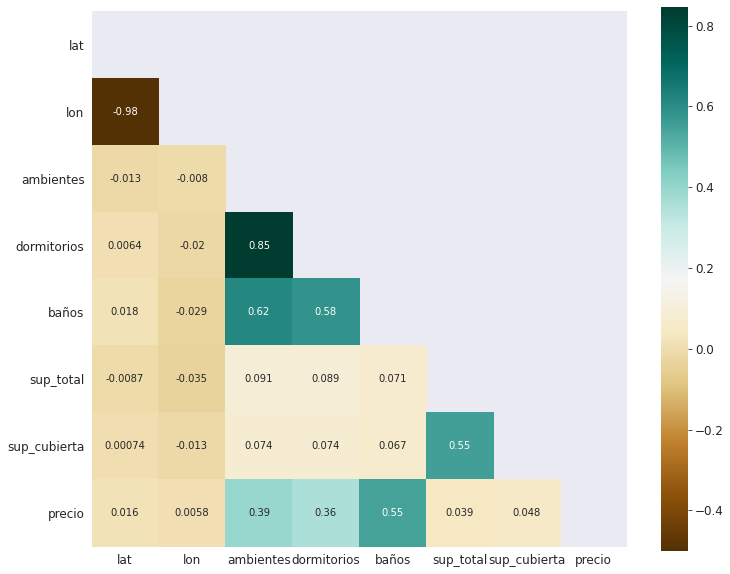

In [ ]:
plt.figure(figsize=(12,10))
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, vmin=-0.5, annot=True, square=True, mask=mask, cmap='BrBG')
plt.show()

##### **Elección de transformaciones**

##### 1. Encoding

Vamos a realizar el encoding de las variables categóricas: ***zona***, ***barrio*** y ***tipo*** para poder utilizar éstos atributos como input del modelo predictor. Las 3 variables son de tipo nominal por lo que aplicaría ***One Hot Enconding***. Sin embargo, la columna ***barrio*** presenta muchas instancias distintas, por lo que realizar un One Hot Encoding de ella generaría muchas columnas adicionales y encarecería el procesamiento de los datos.

##### 2. Análisis de Valores Faltantes

In [ ]:
# Cantidad de valores faltantes por columna del dataset
faltantes = pd.DataFrame(df.isnull().sum(), columns=['faltantes'])
faltantes

,faltantes
lat,6709
lon,6737
zona,0
barrio,0
ambientes,0
dormitorios,0
baños,3717
sup_total,15673
sup_cubierta,15876
precio,0


###### 2.1. Faltantes de variable `baños`

In [ ]:
# Análisis faltantes en variable 'baños'
df_baños_faltantes = df.baños.isnull().groupby([df['tipo']]).sum().astype(int).reset_index(name='missings')
df_baños_faltantes['total'] = df.precio.groupby(df['tipo']).count().values
df_baños_faltantes['rel'] = df_baños_faltantes.missings / df_baños_faltantes.total
df_baños_faltantes.sort_values(by='rel', ascending=False, inplace=True)
# df_baños_faltantes.reset_index(drop=True, inplace=True)
df_baños_faltantes['%'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_baños_faltantes['rel']])
df_baños_faltantes

,tipo,missings,total,rel,%
0,Casa,1216,18459,0.0659,6.59%
1,Departamento,2328,71502,0.0326,3.26%
2,PH,173,9716,0.0178,1.78%


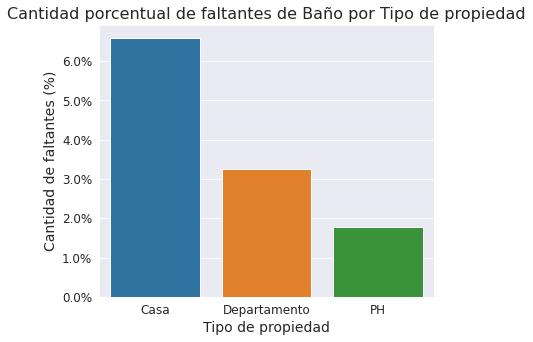

In [ ]:
# Análisis faltantes en variable 'baños'
faltantes_baño = df[df.baños.isna()]
tipos = faltantes_baño.tipo.value_counts()
plt.figure(figsize=(6,5))
plt.title('Cantidad porcentual de faltantes de Baño por Tipo de propiedad')
ax = sns.barplot(data=df_baños_faltantes, x='tipo', y='rel')
plt.ylabel('Cantidad de faltantes (%)')
plt.xlabel('Tipo de propiedad')
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.show()

Para solucionar el tema de los valores faltantes de la variable `baños` podría imputarlos con el valor de la moda para cada `tipo` de propiedad.

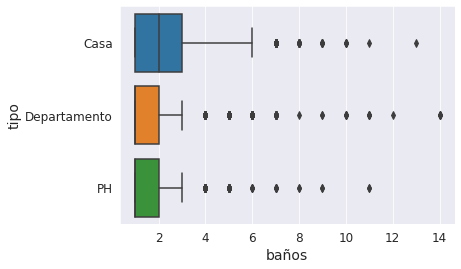

In [ ]:
sns.boxplot(data=df, y='tipo', x='baños', order=df_baños_faltantes.tipo)
plt.show()

In [ ]:
# La moda de la variable `baños` por cada tipo de propiedad
moda_baños_por_tipo = df.groupby(['tipo']).agg(lambda x:x.value_counts().index[0]).baños.reset_index(name='moda_baños')
moda_baños_por_tipo

,tipo,moda_baños
0,Casa,2.0000
1,Departamento,1.0000
2,PH,1.0000


###### 2.2. Faltantes de variable `sup_total` y `sup_cubierta`

In [ ]:
# Separo los datos que tienen missings de superficie (total o cubierta)
mask = np.logical_or(df.sup_cubierta.isna(), df.sup_total.isna())
faltantes_sup = df[mask]

def sup_faltante(row):
  if np.logical_and(pd.isna(row.sup_total), pd.isna(row.sup_cubierta)):
    return 'ambas'
  elif np.logical_and(pd.isna(row.sup_total), ~pd.isna(row.sup_cubierta)):
    return 'total'
  elif np.logical_and(~pd.isna(row.sup_total), pd.isna(row.sup_cubierta)):
    return 'cubierta'
  else:
    return 'ninguna'

faltantes_sup['falta sup'] = faltantes_sup.apply(sup_faltante, axis=1)
faltantes_sup.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo,falta sup
722,-34.5776,-58.4651,Capital Federal,Colegiales,2.0000,1.0000,1.0000,35.0000,nan,89000.0000,Departamento,cubierta
723,nan,nan,Bs.As. G.B.A. Zona Oeste,La Matanza,2.0000,1.0000,1.0000,nan,nan,75000.0000,Departamento,ambas
890,nan,nan,Bs.As. G.B.A. Zona Oeste,La Matanza,3.0000,2.0000,1.0000,nan,nan,120000.0000,Departamento,ambas
891,nan,nan,Bs.As. G.B.A. Zona Oeste,La Matanza,3.0000,2.0000,1.0000,nan,nan,95000.0000,Departamento,ambas
913,-34.5988,-58.3640,Capital Federal,Puerto Madero,3.0000,2.0000,3.0000,165.0000,nan,690000.0000,Departamento,cubierta


In [ ]:
# Vemos las instancias en las que faltan datos de superficie cubierta y/o de superficie total
faltantes_sup.groupby('falta sup').count().precio.reset_index(name='missings')

,falta sup,missings
0,ambas,15217
1,cubierta,659
2,total,456


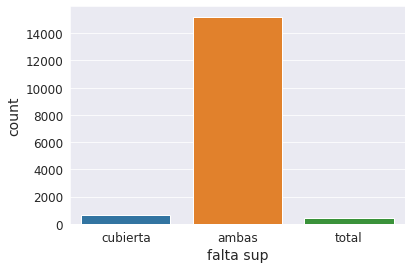

In [ ]:
sns.countplot(data=faltantes_sup, x='falta sup')
plt.show()

Para los casos en que sólo falta una de las superficies, imputaría el valor de la faltante con el valor de la otra.
Para el caso en que faltan ambas superficies las imputaría calculando el precio por metro cuadraado promedio de cada barrio y luego calculo la superficie total dividiendo el `precio` por el `precio_m2` calculado por `barrio`.

###### 2.3. Faltantes de variables `lat` y `lon`

In [ ]:
# Separo los datos que tienen missings de superficie (total o cubierta)
mask = np.logical_or(df.lat.isna(), df.lon.isna())
faltantes_coord = df[mask]

def coord_faltante(row):
  if np.logical_and(pd.isna(row.lat), pd.isna(row.lon)):
    return 'ambas'
  elif np.logical_and(pd.isna(row.lat), ~pd.isna(row.lon)):
    return 'lat'
  elif np.logical_and(~pd.isna(row.lat), pd.isna(row.lon)):
    return 'lon'
  else:
    return 'ninguna'

faltantes_coord['falta coordenada'] = faltantes_coord.apply(coord_faltante, axis=1)
faltantes_coord.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo,falta coordenada
17,nan,nan,Bs.As. G.B.A. Zona Norte,Tigre,2.0000,1.0000,1.0000,53.0000,42.0000,145000.0000,Departamento,ambas
26,nan,nan,Bs.As. G.B.A. Zona Oeste,Morón,2.0000,1.0000,1.0000,45.0000,45.0000,110000.0000,Departamento,ambas
35,nan,nan,Capital Federal,Palermo,2.0000,1.0000,2.0000,81.0000,76.0000,410000.0000,Departamento,ambas
36,nan,nan,Capital Federal,Palermo,2.0000,1.0000,1.0000,42.0000,38.0000,169000.0000,Departamento,ambas
46,nan,nan,Capital Federal,Palermo,2.0000,1.0000,1.0000,52.0000,46.0000,159500.0000,Departamento,ambas


In [ ]:
faltantes_coord.groupby('falta coordenada').count().precio.reset_index(name='missings')

,falta coordenada,missings
0,ambas,6709
1,lon,28


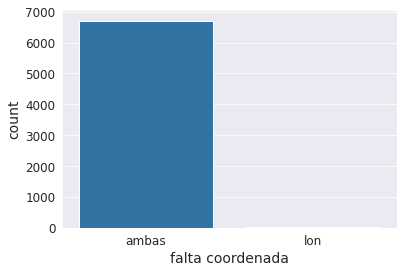

In [ ]:
sns.countplot(data=faltantes_coord, x='falta coordenada')
plt.show()

En este caso completaría las coordenadas `lat` y `lon` de modo de imputarles el promedio de los valores correspondientes a los `barrios` a los cuales pertenecen las instancias.

In [ ]:
df_con_coord = df[~mask]
barrios = df_con_coord.groupby(by='barrio').mean()[['lat', 'lon']].reset_index()
barrios

,barrio,lat,lon
0,Abasto,-34.6048,-58.4138
1,Agronomía,-34.5940,-58.4897
2,Almagro,-34.6069,-58.4216
3,Almirante Brown,-34.8131,-58.3872
4,Avellaneda,-34.6826,-58.3460
...,...,...,...
84,Villa Riachuelo,-34.6901,-58.4729
85,Villa Santa Rita,-34.6156,-58.4819
86,Villa Soldati,-34.6616,-58.4431
87,Villa Urquiza,-34.5738,-58.4850


##### 3. Detección y Eliminación de Outliers

##### **Implementación de transformaciones**

##### 1. Missings

In [ ]:
# Creamos un diccionario para imputar los missings
dict_moda_baños_por_tipo = moda_baños_por_tipo.set_index('tipo').transpose().to_dict('records')[0]
print(dict_moda_baños_por_tipo)

{'Casa': 2.0, 'Departamento': 1.0, 'PH': 1.0}


In [ ]:
# Imputando missings en `baños`
df.baños = df.baños.fillna(df.tipo.map(dict_moda_baños_por_tipo))
df

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
0,-34.6059,-58.3849,Capital Federal,San Cristobal,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,Departamento
1,-34.6241,-58.4121,Capital Federal,Boedo,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,PH
2,-34.5936,-58.4275,Capital Federal,Palermo,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,PH
3,-34.5813,-58.4368,Capital Federal,Palermo,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,PH
4,-34.9142,-57.9382,Bs.As. G.B.A. Zona Sur,La Plata,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,PH
...,...,...,...,...,...,...,...,...,...,...,...
146644,-34.4451,-58.6212,Bs.As. G.B.A. Zona Norte,Tigre,3.0000,2.0000,2.0000,97.0000,80.0000,260000.0000,Departamento
146654,-34.6024,-58.5911,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,3.0000,2.0000,2.0000,161.0000,80.0000,200000.0000,Departamento
146657,-34.4446,-58.9816,Bs.As. G.B.A. Zona Norte,Pilar,1.0000,1.0000,1.0000,50.0000,35.0000,73000.0000,Departamento
146658,-34.4448,-58.9818,Bs.As. G.B.A. Zona Norte,Pilar,2.0000,1.0000,1.0000,38.0000,38.0000,68000.0000,Departamento


In [ ]:
# Verificamos que no haya más missings en `baños`
df.isna().sum()

lat              6709
lon              6737
zona                0
barrio              0
ambientes           0
dormitorios         0
baños               0
sup_total       15673
sup_cubierta    15876
precio              0
tipo                0
dtype: int64

In [ ]:
# Imputando missings en `lat` y `lon`
dict_media_lat_por_barrio = barrios[['barrio','lat']].set_index('barrio').transpose().to_dict('records')[0]
dict_media_lon_por_barrio = barrios[['barrio','lon']].set_index('barrio').transpose().to_dict('records')[0]
df.lat = df.lat.fillna(df.barrio.map(dict_media_lat_por_barrio))
df.lon = df.lon.fillna(df.barrio.map(dict_media_lon_por_barrio))
df.isna().sum()

lat                 0
lon                 0
zona                0
barrio              0
ambientes           0
dormitorios         0
baños               0
sup_total       15673
sup_cubierta    15876
precio              0
tipo                0
dtype: int64

In [ ]:
# Agregamos una columna auxiliar al dataframe para identificar facilmente si falta
# una superficie o las dos, para facilitar la imputación de missings de superficie.
df['falta_sup'] = df.apply(sup_faltante, axis=1)
df.head()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo,falta_sup
0,-34.6059,-58.3849,Capital Federal,San Cristobal,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,Departamento,ninguna
1,-34.6241,-58.4121,Capital Federal,Boedo,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,PH,ninguna
2,-34.5936,-58.4275,Capital Federal,Palermo,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,PH,ninguna
3,-34.5813,-58.4368,Capital Federal,Palermo,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,PH,ninguna
4,-34.9142,-57.9382,Bs.As. G.B.A. Zona Sur,La Plata,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,PH,ninguna


In [ ]:
df.falta_sup.unique()

array(['ninguna', 'cubierta', 'ambas', 'total'], dtype=object)

In [ ]:
# Imputamos los missings de `sup_total` con los valores de `sup_cubierta`
df.loc[df[df.falta_sup == 'total'].index, 'sup_total'] = df[df.falta_sup == 'total'].sup_cubierta

In [ ]:
# Imputamos los missings de `sup_cubierta` con los valores de `sup_total`
df.loc[df[df.falta_sup == 'cubierta'].index, 'sup_cubierta'] = df[df.falta_sup == 'cubierta'].sup_total

In [ ]:
# Verificamos que ahora tenemos misma cantidad de missings de `lat` y `lon`
df.isna().sum()

lat                 0
lon                 0
zona                0
barrio              0
ambientes           0
dormitorios         0
baños               0
sup_total       15217
sup_cubierta    15217
precio              0
tipo                0
falta_sup           0
dtype: int64

In [ ]:
# Creamos una columna calculada con el precio por metro cuadrado
df['precio_m2'] = df.precio / df.sup_total
# Y luego creamos un diccionario con el precio por metro cuadrado por barrio
dict_precio_m2_por_barrio = df.groupby('barrio').mean()['precio_m2'].to_dict()

In [ ]:
# Finalmente asigno el precio por metro cuadrado de cada barrio a cada fila que contiene faltantes
df.precio_m2 = df.precio_m2.fillna(df.barrio.map(dict_precio_m2_por_barrio))
# E imputo los valores faltantes de superficie con el cálculo de precio dividido el precio por metro cuadrado.
df.sup_total = df.sup_total.fillna(df.precio / df.precio_m2)
# Finalmente imputo la superficie cubierta con el valor de superficie total.
df.sup_cubierta = df.sup_cubierta.fillna(df.sup_total)

In [ ]:
# Verifico que no tengo más missings.
df.isna().sum()

lat             0
lon             0
zona            0
barrio          0
ambientes       0
dormitorios     0
baños           0
sup_total       0
sup_cubierta    0
precio          0
tipo            0
falta_sup       0
precio_m2       0
dtype: int64

In [ ]:
# Descarto las columnas auxiliares que no usaremos más.
df.drop(columns=['precio_m2', 'falta_sup'], inplace=True)

##### 2. Encoding

In [ ]:
! pip install feature_engine

In [ ]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)


In [ ]:
# Importamos las librerias que son utiles para esto
import feature_engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
import category_encoders as ce
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Posible opción para encoding: asignar un número a cada categoría

In [ ]:
from sklearn.preprocessing import LabelEncoder
df2 = df.copy()
cols = ('zona', 'barrio', 'tipo')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df2[c].values)) 
    df2[c] = lbl.transform(list(df[c].values))

# shape        
print('Shape all_data: {}'.format(df2.shape))

Shape all_data: (99677, 11)


In [ ]:
df2.head()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
0,-34.6059,-58.3849,3,63,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,1
1,-34.6241,-58.4121,3,11,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,2
2,-34.5936,-58.4275,3,48,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,2
3,-34.5813,-58.4368,3,48,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,2
4,-34.9142,-57.9382,2,33,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,2


Otra opción es realizar un Target Encoding

In [ ]:
df3 = df.copy()
cols = ('zona', 'barrio', 'tipo')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl=ce.TargetEncoder(cols=c)
    df3[c] = lbl.fit_transform(df3[c], df['precio']) 

# shape        
print('Shape all_data: {}'.format(df3.shape))

Shape all_data: (99677, 11)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
df3.head()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
0,-34.6059,-58.3849,258249.1514,130576.7552,7.0000,7.0000,2.0000,140.0000,140.0000,153000.0000,231302.0609
1,-34.6241,-58.4121,258249.1514,148584.0431,2.0000,1.0000,2.0000,70.0000,58.0000,159000.0000,171013.6994
2,-34.5936,-58.4275,258249.1514,378600.3025,2.0000,1.0000,1.0000,45.0000,45.0000,125000.0000,171013.6994
3,-34.5813,-58.4368,258249.1514,378600.3025,2.0000,1.0000,1.0000,85.0000,50.0000,295000.0000,171013.6994
4,-34.9142,-57.9382,180894.9458,146513.0062,2.0000,1.0000,1.0000,50.0000,35.0000,40000.0000,171013.6994


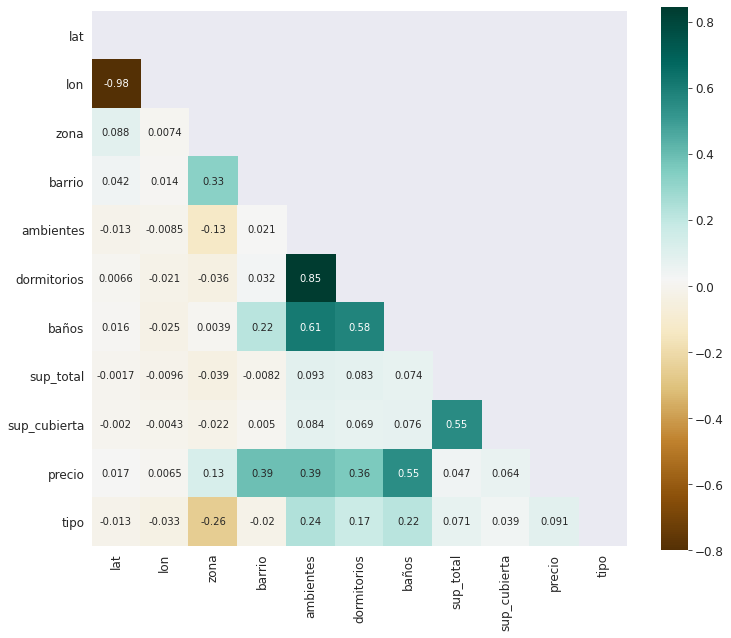

In [ ]:
plt.figure(figsize=(12,10))
corr_matrix = df3.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, vmin=-0.8, annot=True, square=True, mask=mask, cmap='BrBG')
plt.show()

###### 1.1. One Hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [ ]:
data = df[['barrio', 'tipo', 'sup_total', 'precio']]
column_trans = make_column_transformer(
    (OneHotEncoder(sparse=False),['barrio', 'tipo']),
    remainder='passthrough'
)
data = data.dropna()
X = data[['barrio', 'tipo', 'sup_total']]
y = data['precio']
print(X.shape)
print(y.shape)

(99677, 3)
(99677,)


In [ ]:
X.head()

,barrio,tipo,sup_total
0,San Cristobal,Departamento,140.0000
1,Boedo,PH,70.0000
2,Palermo,PH,45.0000
3,Palermo,PH,85.0000
4,La Plata,PH,50.0000


In [ ]:
column_trans.fit_transform(X)

array([[  0.,   0.,   0., ...,   1.,   0., 140.],
       [  0.,   0.,   0., ...,   0.,   1.,  70.],
       [  0.,   0.,   0., ...,   0.,   1.,  45.],
       ...,
       [  0.,   0.,   0., ...,   1.,   0.,  50.],
       [  0.,   0.,   0., ...,   1.,   0.,  38.],
       [  0.,   0.,   0., ...,   1.,   0.,  75.]])

##### 3. Ouliers

In [ ]:
df3.describe()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
count,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000,99677.0000
mean,-34.6057,-58.4694,233359.3667,233359.4273,3.1197,1.9969,1.5952,196.0609,114.7656,233359.3667,233359.3667
std,0.5467,0.5660,37270.7943,113607.6211,1.4320,1.1490,0.8894,1570.9903,806.7505,287797.4140,26267.3257
min,-35.1508,-180.0000,154200.2163,95836.8802,1.0000,0.0000,1.0000,1.0000,1.0000,6000.0000,171013.6994
25%,-34.6347,-58.5226,237758.7481,152440.0076,2.0000,1.0000,1.0000,52.0000,47.9661,110000.0000,231302.0609
50%,-34.6014,-58.4511,258249.1514,203715.8454,3.0000,2.0000,1.0000,80.0000,70.0000,160000.0000,231302.0609
75%,-34.5688,-58.4049,258249.1514,294680.2353,4.0000,3.0000,2.0000,149.0000,117.0000,260000.0000,231302.0609
max,85.0511,-57.8058,258249.1514,935940.7996,35.0000,15.0000,14.0000,169000.0000,126062.0000,32434232.0000,274144.4573


La superficie mínima (tanto la total como la cubierta) siguen siendo de 1 $m^2$ (valor que no tiene mucho sentido), por lo que voy a filtrar el dataset para superficies mayores a 25 $m^2$.

In [ ]:
df3 = df3[df3.sup_total > 25]
df3 = df3[df3.sup_cubierta > 25]
df3.shape

(98412, 11)

In [ ]:
df3.describe()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
count,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000,98412.0000
mean,-34.6057,-58.4697,233212.9668,233497.5346,3.1423,2.0099,1.6020,198.1689,115.9781,235303.5378,233411.8778
std,0.5502,0.5695,37310.3665,113745.6890,1.4240,1.1480,0.8923,1580.9233,811.8474,289019.8933,26374.6838
min,-35.1508,-180.0000,154200.2163,95836.8802,1.0000,0.0000,1.0000,25.0023,25.0023,6000.0000,171013.6994
25%,-34.6352,-58.5234,237758.7481,152440.0076,2.0000,1.0000,1.0000,53.0000,48.0000,110000.0000,231302.0609
50%,-34.6014,-58.4516,258249.1514,203715.8454,3.0000,2.0000,1.0000,81.0000,71.0000,163000.0000,231302.0609
75%,-34.5684,-58.4052,258249.1514,294680.2353,4.0000,3.0000,2.0000,150.0000,118.0000,260228.2500,231302.0609
max,85.0511,-57.8058,258249.1514,935940.7996,35.0000,15.0000,14.0000,169000.0000,126062.0000,32434232.0000,274144.4573


In [ ]:
# Vamos a eliminar los outliers con el método del rango intercuartílico.
df_out = df3.copy()
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
      
    print("El IQR de la columna %s es: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

columns_to_filter = ['sup_total', 'sup_cubierta', 'precio']

for i in columns_to_filter:
    removeOutliers(df_out, i)
    # Assigning filtered data back to our orginal variable
    df_out = filtered_data
print("Shape of data after outlier removal is: ", df_out.shape)

El IQR de la columna sup_total es: 97.0
El IQR de la columna sup_cubierta es: 54.0
El IQR de la columna precio es: 125000.0
Shape of data after outlier removal is:  (78429, 11)


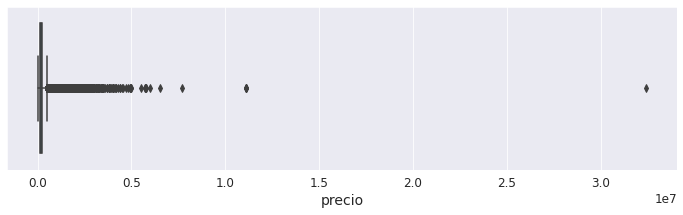

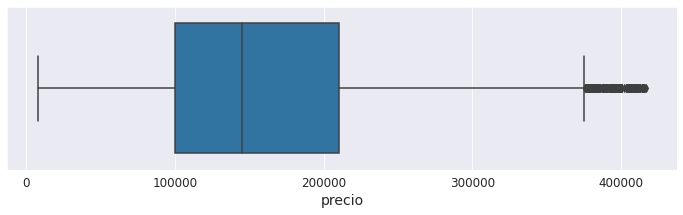

In [ ]:
plt.figure(figsize=(12,3))
sns.boxplot(data=df3, x='precio')
plt.show()
plt.figure(figsize=(12,3))
sns.boxplot(data=df_out, x='precio')
plt.show()

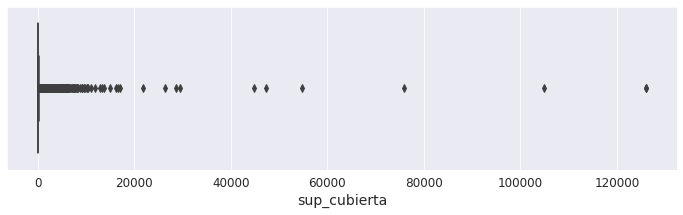

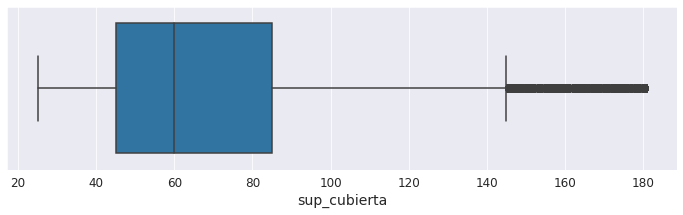

In [ ]:
plt.figure(figsize=(12,3))
sns.boxplot(data=df3, x='sup_cubierta')
plt.show()
plt.figure(figsize=(12,3))
sns.boxplot(data=df_out, x='sup_cubierta')
plt.show()

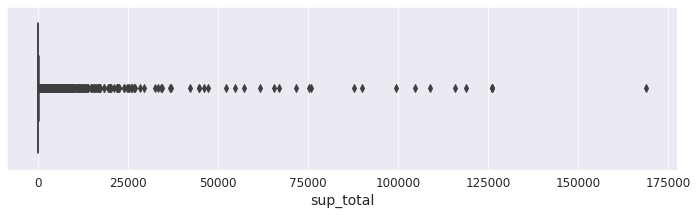

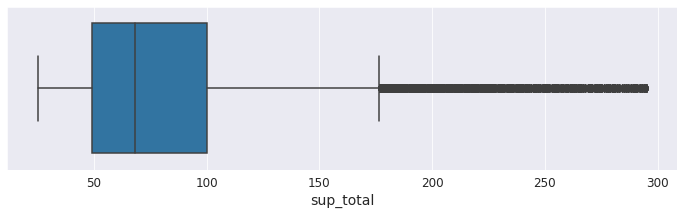

In [ ]:
plt.figure(figsize=(12,3))
sns.boxplot(data=df3, x='sup_total')
plt.show()
plt.figure(figsize=(12,3))
sns.boxplot(data=df_out, x='sup_total')
plt.show()

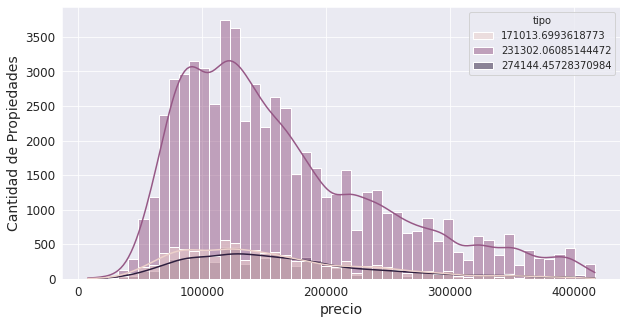

In [ ]:
plt.figure(figsize=(10,5))
g = sns.histplot(data=df_out, x='precio', kde=True, bins=50, hue='tipo')
plt.ylabel("Cantidad de Propiedades")
plt.show()

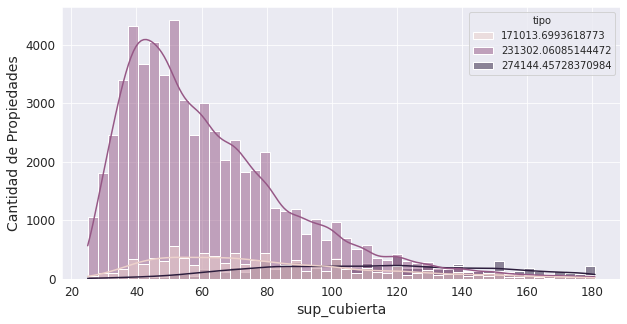

In [ ]:
plt.figure(figsize=(10,5))
g = sns.histplot(data=df_out, x='sup_cubierta', kde=True, bins=50, hue='tipo')
plt.ylabel("Cantidad de Propiedades")
plt.show()

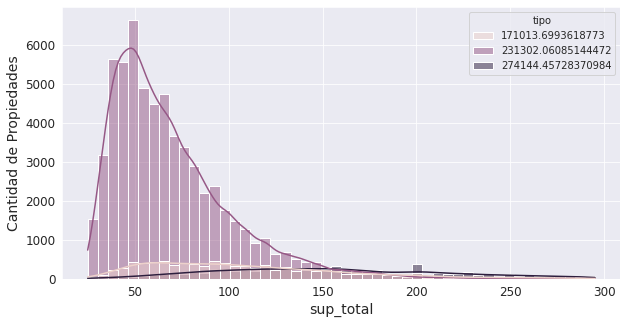

In [ ]:
plt.figure(figsize=(10,5))
g = sns.histplot(data=df_out, x='sup_total', kde=True, bins=50, hue='tipo')
plt.ylabel("Cantidad de Propiedades")
plt.show()

In [ ]:
df_out.describe()

,lat,lon,zona,barrio,ambientes,dormitorios,baños,sup_total,sup_cubierta,precio,tipo
count,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000,78429.0000
mean,-34.6026,-58.4644,235818.1333,221921.9302,2.7634,1.7487,1.3548,81.8980,69.2531,164081.4251,228509.7317
std,0.6121,0.6299,36262.1124,92735.9345,1.0832,0.9258,0.6030,46.3943,32.2693,81565.2739,24034.6888
min,-35.1208,-180.0000,154200.2163,95836.8802,1.0000,0.0000,1.0000,25.0023,25.0023,7500.0000,171013.6994
25%,-34.6313,-58.5124,237758.7481,151307.3264,2.0000,1.0000,1.0000,49.0000,45.0000,100000.0000,231302.0609
50%,-34.6022,-58.4518,258249.1514,191678.6180,3.0000,2.0000,1.0000,68.0000,60.0000,145000.0000,231302.0609
75%,-34.5712,-58.4078,258249.1514,259969.8507,3.0000,2.0000,2.0000,100.0000,85.0000,210000.0000,231302.0609
max,85.0511,-57.8377,258249.1514,935940.7996,35.0000,15.0000,14.0000,295.0000,180.8678,417000.0000,274144.4573


In [112]:
df_out.shape

(78429, 11)

##### **Reentrenamiento de <u>Modelo Sprint 1<u>**

In [ ]:
# Definimos las variables de predictoras y la variable a predecir
data = df_out.copy()
# X = data.drop(['precio', 'tipo', 'barrio', 'zona'], axis=1)
X = data.drop(['precio'], axis=1)
# X = data[['surface_total']]
y = data['precio']

In [ ]:
# En caso que la variable predictora sea una sola, graficamos la variable predecir en función de la predictora.
# Si no se cumple la condición, no se realiza el gráfico.
if X.shape[1] == 1:
  plt.figure(figsize=(10, 8))
  plt.scatter(X,y, s = 2)
  plt.xlabel('Superficie total [m2]')
  plt.ylabel('Precio [usd]')
  plt.legend()
  plt.show()

In [ ]:
# Hacemos la división entre datos de entrenamiento y datos de testeo.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54900, 10) (54900,) (23529, 10) (23529,)


In [ ]:
# Importamos las librerías de los modelos a utilizar
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Instanciamos lo modelos
linear_model = LinearRegression()
tree_regressor = DecisionTreeRegressor(max_depth=17, random_state=42)
knn_regressor = KNeighborsRegressor(n_neighbors=3)

In [ ]:
# Entrenamos los modelos
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [ ]:
# En caso que la variable predictora sea una sola, graficamos la variable predecir en función de la predictora para los tres modelos.
if X.shape[1] == 1 :
  plt.figure(figsize = (20,6))

  plt.subplot(1,3,1)
  plt.scatter(X,y, s = 2)
  plt.plot(X,linear_model.predict(X),label ='Regresion Lineal', c = 'g')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

  plt.subplot(1,3,2)
  plt.scatter(X,y, s = 2)
  plt.plot(X,tree_regressor.predict(X),label ='Árbol de Decisión', c = 'g')

  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

  plt.subplot(1,3,3)
  plt.scatter(X,y, s = 2)
  plt.plot(X,knn_regressor.predict(X),label ='knn', c = 'g')

  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

  plt.tight_layout()
  plt.show()

Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 48797.110297772
Raíz del error cuadrático medio en Test: 48659.27351228932


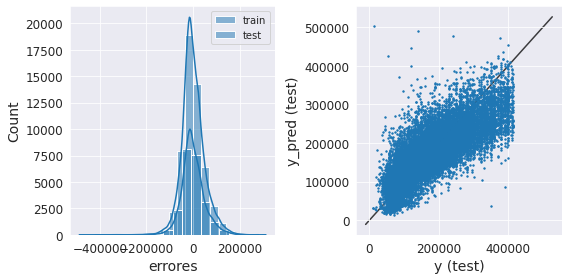

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 20133.720728002492
Raíz del error cuadrático medio en Test: 42174.422937858246


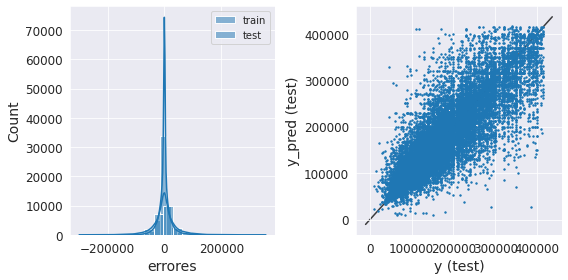

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 27578.02032064895
Raíz del error cuadrático medio en Test: 40249.466335531906


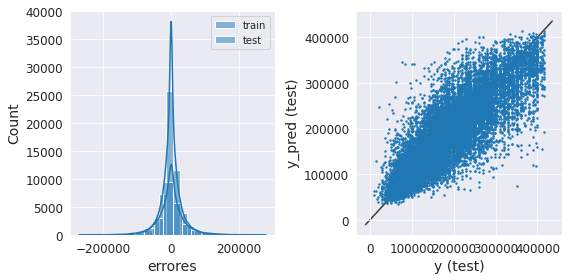

In [ ]:
# Luego analizamos la distribución de los errores de las predicciones de cada modelo
# y calculamos la raíz del error cuadrático medio de la cada modelo con los hiperparámetros utilizados
from sklearn.metrics import mean_squared_error
import seaborn as sns
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([linear_model, tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred, bins = 20, label = 'train', kde=True)
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test', kde=True)
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Ahora vamos a analizar el R2 que puede darnos una idea más comparable del 
# ajuste de los datos predichos con los datos reales de la muestra.
# Importamos la metrica
from sklearn.metrics import r2_score

In [ ]:
# Primero calculamos el R^2 del benchmark: Modelo de Regresión Lineal
r2_test_lin = r2_score(y_test,linear_model.predict(X_test))
r2_train_lin = r2_score(y_train,linear_model.predict(X_train))
print('r2_train_lin:', r2_train_lin)
print('r2_test_lin:', r2_test_lin)

r2_train_lin: 0.6417436545174389
r2_test_lin: 0.6448439689483902


In [ ]:
# Vamos a calcular los R2 variando los hiperparámetros de entrenamiento del modelo
# Definimos las listas vacias para los valores de accuracy deseados
lista_rsme_train = []
lista_rsme_test = []
lista_r2_train = []
lista_r2_test = []

# Definimos la lista de valores de k que vamos a explorar
max_depths = np.arange(1,26, 1)

# Generamos un loop sobre los distintos valores de k 
for d in max_depths:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = DecisionTreeRegressor(max_depth = d)
    
    # Entrenar el modelo
    clf.fit(X_train, y_train)
    

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    # train_acc = clf.score(X_train, y_train_pred)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    # test_acc = clf.score(X_test, y_test_pred)
    
    # Agregar la información a las listas
    lista_rsme_train.append(rmse_train)
    lista_rsme_test.append(rmse_test)
    lista_r2_train.append(r2_train)
    lista_r2_test.append(r2_test)
  

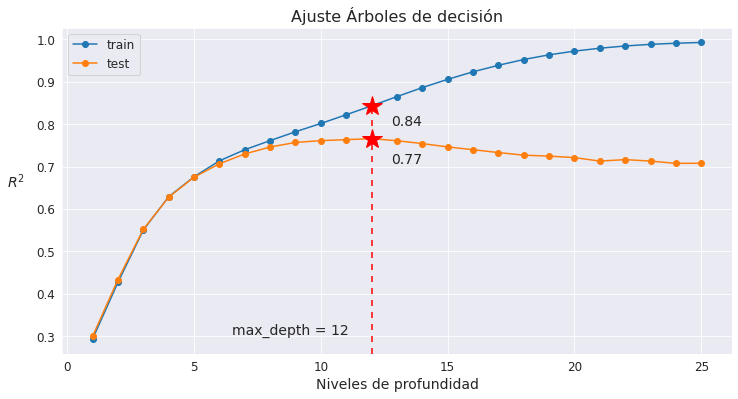

In [ ]:
# A continuación creamos el gráfico de los R^2 en función de los niveles de profundidad máxima del modelo de Árboles de decisión.
# Adicionalmente, marcamos el punto óptimo que maximiza el R2 en los datos de testeo.
# Este punto sería el máximo a considerar para definir la profundidad del Árbol de decisión, ya que queremos minimizar el costo computacional de entrenamiento.
plt.figure(figsize=(12,6))
plt.plot(max_depths, lista_r2_train,'o-',label='train' )
plt.plot(max_depths, lista_r2_test,'o-',label='test')

max_r2_test_tree = max(lista_r2_test)
# max_r2_test_tree = np.quantile(lista_r2_test, 0.55, interpolation='nearest')
max_depth = max_depths[np.where(lista_r2_test == max_r2_test_tree)[0][0]]
r_train_tree = lista_r2_train[np.where(lista_r2_test == max_r2_test_tree)[0][0]]

plt.plot(max_depth, max_r2_test_tree, '*r', markersize=20)
plt.plot(max_depth, r_train_tree, '*r', markersize=20)
y_min = plt.gca().get_ylim()[0]
y_max = plt.gca().get_ylim()[1]
plt.axvline(x=max_depth, color='r', ymax=(r_train_tree - y_min) / (y_max-y_min), dashes=(4,4))

plt.annotate(np.round(max_r2_test_tree,2), xy=(max_depth, max_r2_test_tree), xytext=(20, -25), size=14, xycoords='data', textcoords='offset points')
plt.annotate(np.round(r_train_tree, 2), xy=(max_depth, r_train_tree), xytext=(20, -20), size=14,xycoords='data', textcoords='offset points')
plt.annotate("max_depth = " + str(np.round(max_depth, 0)), xy=(max_depth, y_min), xytext=(-140, 20), size=14,xycoords='data', textcoords='offset points')

plt.legend(fontsize=12)
plt.title('Ajuste Árboles de decisión')
plt.xlabel('Niveles de profundidad')
plt.ylabel('$R^2$', rotation=0, size=14, labelpad=20)

plt.show()

In [ ]:
# Repetimos lo anterior, pero para el modelo de Vecinos más cercanos
# Definimos las listas vacias para los valores de accuracy deseados
lista_rsme_train = []
lista_rsme_test = []
lista_r2_train = []
lista_r2_test = []
time_list = []
# fisrt_time = milisecs(datetime.now())

# Definimos la lista de valores de k que vamos a explorar
k_vecinos = np.arange(1,26, 1)

# Generamos un loop sobre los distintos valores de k 
for k in k_vecinos:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsRegressor(n_neighbors = k)
    
    # Entrenar el modelo
    clf.fit(X_train, y_train)

    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    # train_acc = clf.score(X_train, y_train_pred)
    # time = milisecs(datetime.now()) - fisrt_time
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    # test_acc = clf.score(X_test, y_test_pred)
    
    # Agregar la información a las listas
    lista_rsme_train.append(rmse_train)
    lista_rsme_test.append(rmse_test)
    lista_r2_train.append(r2_train)
    lista_r2_test.append(r2_test)
    # time_list.append(time)

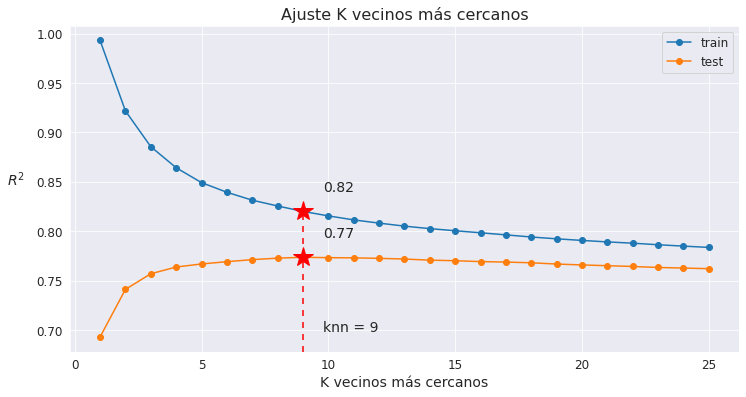

In [ ]:
# A continuación creamos el gráfico de los R^2 en función de la cantidad de vecinos del modelo de KNN.

plt.figure(figsize=(12,6))
plt.plot(k_vecinos, lista_r2_train,'o-',label='train' )
plt.plot(k_vecinos, lista_r2_test,'o-',label='test')

max_r2_test_knn = max(lista_r2_test)
n = k_vecinos[np.where(lista_r2_test == max_r2_test_knn)[0][0]]
r_train_knn = lista_r2_train[np.where(lista_r2_test == max_r2_test_knn)[0][0]]

plt.plot(n, max_r2_test_knn, '*r', markersize=20)
plt.plot(n, r_train_knn, '*r', markersize=20)
y_min = plt.gca().get_ylim()[0]
y_max = plt.gca().get_ylim()[1]
plt.axvline(x=n, color='r', ymax=(r_train_knn-y_min) / (y_max-y_min), dashes=(4,4))

plt.annotate(np.round(max_r2_test_knn,2), xy=(n, max_r2_test_knn), xytext=(20, 20), size=14, xycoords='data', textcoords='offset points')
plt.annotate(np.round(r_train_knn, 2), xy=(n, r_train_knn), xytext=(20, 20), size=14,xycoords='data', textcoords='offset points')
plt.annotate("knn = " + str(np.round(n, 0)), xy=(n, y_min), xytext=(20, 20), size=14,xycoords='data', textcoords='offset points')

plt.legend(fontsize=12)
plt.title('Ajuste K vecinos más cercanos')
plt.xlabel('K vecinos más cercanos')
plt.ylabel('$R^2$', rotation=0, size=14, labelpad=20)
plt.show()

In [ ]:
# Creamos una tabla con los resultados
# LIN = Regresión lineal
# TREE = Modelo de Árboles de decisión
# LIN = Regresión lineal

res2 = pd.DataFrame([['-', np.round(r2_train_lin, 2), np.round(r2_test_lin, 2)],
                    [max_depth, np.round(r_train_tree, 2), np.round(max_r2_test_tree, 2)], 
                    [n, np.round(r_train_knn, 2), np.round(max_r2_test_knn, 2)]], 
                   columns=['Parámetro', 'R2_train', 'R2_test'], index=['LIN', 'TREE', 'KNN'])
res2 = res2.transpose()
res2

,LIN,TREE,KNN
Parámetro,-,12,9
R2_train,0.6400,0.8400,0.8200
R2_test,0.6400,0.7700,0.7700


In [111]:
# Resultados del sprint 1
res1 = pd.DataFrame([['-', 0.55, 0.55],[17, 0.95, 0.77],[3, 0.88, 0.75]], 
                   columns=['Parámetro', 'R2_train', 'R2_test'], index=['LIN', 'TREE', 'KNN'])
res1 = res1.transpose()
res1

,LIN,TREE,KNN
Parámetro,-,17,3
R2_train,0.5500,0.9500,0.8800
R2_test,0.5500,0.7700,0.7500


##### **Evaluación de desempeño**

### **Modelos Avanzados**
***

##### **Elección de Modelos Avanzados**

##### **Entrenamiento de modelos**

##### **Evaluación de modelos**

##### **Optimización de hiperparámetros**

##### **Comparación de los tres modelos**

### **Interpretación de Modelos**
***

##### **Responder preguntas planteadas**

##### **Distribución de los errores**

##### **Fallas de los modelos**

### **Cierre**
***

##### **Conclusiones**